In [1]:
import pandas as pd
import numpy as np

#自data1.txt中引入數據
#預設沒有標頭的讀取方式
dataset = pd.read_csv('data1.txt', header=None)
#確認資料無誤
print(dataset)


#取得dataset中從第一到最後一個row，第一個column
#並將其換成numpy運算可接受的格式
X = np.array(dataset.iloc[ : , 0].values)
X = np.array_split(X, len(X))

#同X軸資料，處理Y軸資料
Y = np.array(dataset.iloc[ : , 1].values)


          0         1
0    6.1101  17.59200
1    5.5277   9.13020
2    8.5186  13.66200
3    7.0032  11.85400
4    5.8598   6.82330
..      ...       ...
92   5.8707   7.20290
93   5.3054   1.98690
94   8.2934   0.14454
95  13.3940   9.05510
96   5.4369   0.61705

[97 rows x 2 columns]


In [2]:
def number_rounding(number):
    
    #找到四捨五入最近的整數回傳
    if number - int(number) >= 0.5:
        return int(number + 1)
    else:
        return int(number)

def shuffle_split_number(n_samples, test_size, train_size):
    
    #確認資料分割時的數量大小
    #檢查有沒有輸入任一大小
    #若沒有則分配測試大小比例為0.25
    if test_size is None and train_size is None:
        test_size = 0.25
    
    #如果test_size有值則利用test_size找出train的數量
    if test_size is not None:
        n_test = number_rounding(n_samples * test_size)
        n_train = n_samples - n_test
    
    #如果沒有test_size則反之
    elif train_size is not None:
        n_train = number_rounding(n_samples * train_size)
        n_test = n_samples - n_train

    #確認兩個回傳大小後回傳
    print("訓練大小:", n_train, 
          "測試大小:", n_test)
    return n_train, n_test


In [3]:
def shuffle_split(n_train, n_test, random_state):
    
    #由隨機參數給定隨機值
    print("本次隨機變數:", random_state)
    rng = np.random.RandomState(random_state)
    
    #創建一個數量等於n_train + n_test的矩陣
    #並且打亂，決定洗牌結果
    n_samples = rng.permutation(np.arange(0, n_train + n_test))
    
    #將洗牌後的矩陣取前面作為訓練，後半作為測試回傳
    print("本次訓練用數據編號:")
    for i in n_samples[ : n_train]:
        print(i, end = ' ')
    print("\n本次測試用數據編號:")
    for i in n_samples[n_train: ]:
        print(i, end = ' ')
    
    return n_samples[ : n_train], n_samples[n_train: ]


In [4]:
def my_train_test_split(*arrays):
    
    #將測試比例設為0.25
    #設定隨機狀態參數
    test_size = 0.25
    random_state = 12345
    
    #檢查有無資料輸入
    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("至少需要一組矩陣資料輸入")
    
    #獲取資料長度
    n_samples = len(arrays[0])
    #獲得訓練與測試的數量
    #將測試比例設為0.25
    n_train, n_test = shuffle_split_number(n_samples, test_size, train_size = None)

    #得到訓練與測試的對應數字編號
    train, test = shuffle_split(n_train = n_train,
                                n_test = n_test,
                                random_state = random_state)
    
    #從矩陣中以編號取得對應的數值做成矩陣回傳
    X_train = [arrays[0][n] for n in train]
    X_test = [arrays[0][n] for n in test]
    Y_train = [arrays[1][n] for n in train]
    Y_test = [arrays[1][n] for n in test]
    
    return X_train, X_test, Y_train, Y_test


In [5]:
#將資料分割為訓練以及驗證用
X_train, X_test, Y_train, Y_test = my_train_test_split(X, Y)


訓練大小: 73 測試大小: 24
本次隨機變數: 12345
本次訓練用數據編號:
68 84 54 57 20 47 71 39 60 63 25 4 33 13 49 9 52 45 40 28 90 85 62 48 89 37 2 6 50 74 72 70 30 35 75 26 0 17 87 21 78 42 18 93 46 22 76 83 58 79 32 24 82 27 16 67 12 19 86 44 65 66 8 51 53 92 69 88 15 5 3 64 94 
本次測試用數據編號:
61 31 55 56 91 23 43 7 38 81 10 77 11 73 80 14 59 95 96 34 41 36 1 29 

In [6]:
class LinearRegression():
    
    #初始化class，設定iteration次數，learning_rate=1e-1，使用正規化
    def __init__(self, X, Y, num_iteration = int(1e+3), 
                             learning_rate = 1e-1, 
                             is_normalize = True):
        
        #資料儲存
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.count = len(X)

        #機器學習係數
        self.num_iteration = num_iteration
        self.learning_rate = learning_rate
        
        #正規化係數
        self.is_normalize = is_normalize
        self.normalize_min = np.min(self.X, axis = 0)
        self.normalize_range = 0
        
        #迭代用矩陣
        self.weight = np.zeros((2, 1))
        self.cost_history = np.empty(num_iteration)
        
    def fit(self):
        
        X = self.X
        Y = self.Y
        #計數本次資料多寡
        count = self.count
    
        #正規化
        if self.is_normalize is True:
            X = self.min_max_normalize(X)
    
        #在X矩陣中加入一列為1的矩陣
        #用以更新新的值
        X = np.hstack((np.ones((count, 1)), X))
        Y = Y.reshape(Y.shape[0], 1)
    
        #根據iteration次數更新參數
        for i in range(self.num_iteration):
            #矩陣相乘得到迭代後的值
            Y_pred = X.dot(self.weight)
            
            #將新的預測與實際的y丟入cost function
            #取得cost數值並且記錄
            cost = self.cost_function(Y_pred, Y, count)
            self.cost_history[i] = cost
            
            #更新 Gradient Descent
            self.gradient_descent(X, Y_pred, Y, count)
            
    
    def min_max_normalize(self, X):
        #正規化 Min-Max normalization
        #公式：X_norm = (X - X_min) / (X_max - X_min)
        #參考：https://ithelp.ithome.com.tw/articles/10293893
        self.normalize_range = np.max(X, axis = 0) - np.min(X, axis = 0)
        try:
            return (X - self.normalize_min) / self.normalize_range
        except ValueError:
            #預防除數為0
            print("division by zero!")
        
    def cost_function(self, Y_pred, Y, count):
        #利用 Mean Square Error計算誤差
        #將每一筆資料算差值後總和平均
        #多除一個2抵掉之後微分得到的2減少計算
        return 1/(2*count) * np.sum((Y_pred - Y)**2)
    
    def gradient_descent(self, X, Y_pred, Y, count):
        #根據Y_pred的預測值
        #逐步調整權重(weight)，慢慢逼近最佳解，以達到『損失函數最小化』
        #對X做偏微分，找出下降後最接近0(水平谷底)的值
        #並且利用.reshape(-1, 1)回到原本權重格式
        gd = 1/count * np.sum((Y_pred - Y) * X, axis = 0).reshape(-1, 1)
        
        #調整後的權重 = 原權重  - (學習率 * 梯度)
        self.weight -= self.learning_rate * gd
    
    def predict(self, X_test):
        #本次預測資料
        X = np.array(X_test)
        count = len(X)
        
        #查看是否有正規化
        if self.is_normalize:
            X = (X - self.normalize_min) / self.normalize_range
        
        #利用已經完成的權重，進行一次預測
        X = np.hstack((np.ones((count, 1)), X))
        Y_pred = X.dot(self.weight)
        
        #回傳預測值
        return Y_pred
    
    def get_slope(self):
        #(1, a) - (0, b) / 1 = 斜率
        return Regressor.predict([[1]]) - Regressor.predict([[0]])
    
    def get_intercept(self):
        # X軸上為0時的預測Y值為截距
        return Regressor.predict([[0]])
    
    def get_cost_history(self):
        #返回兩個矩陣，計數以及紀錄
        return np.arange(0, len(self.cost_history)), self.cost_history
    
    def get_score(self, Y_test, Y_pred):
        #計算分數
        #詳見參考：https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
        u = ((Y_test - Y_pred) ** 2).sum()
        v = (Y_test - np.mean(Y_test) ** 2).sum()
        return (1 - u / v)
    

In [7]:
#基本線性回歸
Regressor = LinearRegression(X = X_train, Y = Y_train, is_normalize  = True)
Regressor.fit()

#取得預測的Y值
Y_pred = Regressor.predict(X_test)
print("-----訓練結果-----")
print("斜率：%.2f"%float(Regressor.get_slope()))
print("截距：%.2f"%float(Regressor.get_intercept()))
print("準確率:%.2f"%float(Regressor.get_score(Y_test, Y_pred)), "%")


-----訓練結果-----
斜率：1.16
截距：-3.58
準確率:51.31 %


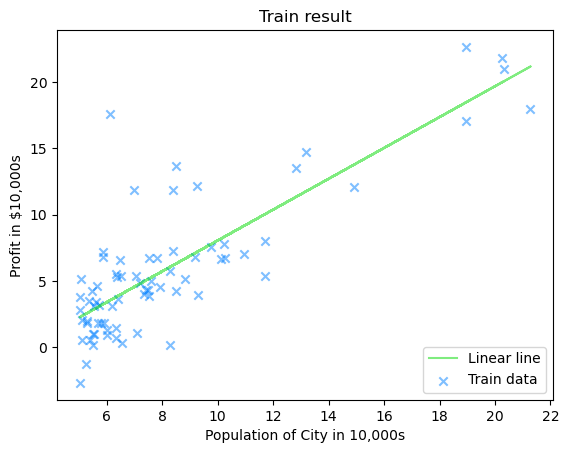

In [8]:
#載入繪圖工具
import matplotlib.pyplot as plt

#繪製訓練用資料點
plt.scatter(X_train, Y_train, color = '#0080FF',marker = 'x', alpha = 0.5)
#繪製訓練完的線
plt.plot(X_train, Regressor.predict(X_train), color = '#00DB00', alpha = 0.5)

plt.title("Train result")
plt.legend(labels = ["Linear line","Train data"], loc = "lower right");
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')
plt.show()


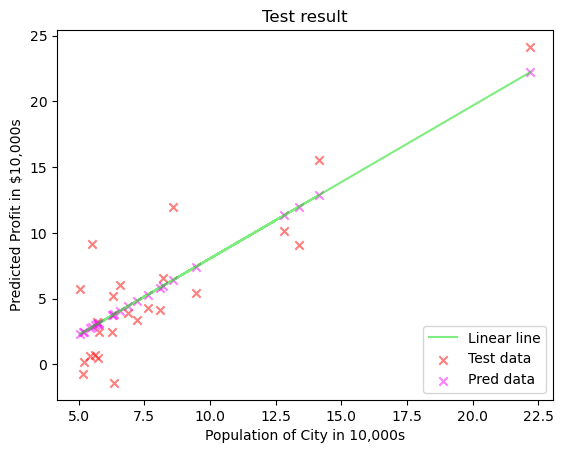

In [9]:
#繪製測試結果
#繪製被選出來的測試資料
plt.scatter(X_test, Y_test, color = '#FF0000',marker = 'x', alpha = 0.5)

#繪製預測線
plt.plot(X_test, Regressor.predict(X_test), color = '#00DB00', alpha = 0.5)
#繪製預測點
plt.scatter(X_test, Y_pred, color = '#FF00FF',marker = 'x', alpha = 0.5)

plt.title("Test result")
plt.legend(labels = ["Linear line", "Test data", "Pred data"], loc = "lower right");
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Predicted Profit in $10,000s')
plt.show()


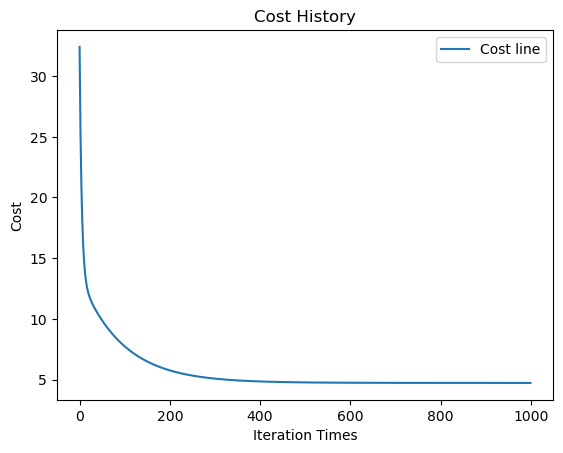

In [10]:
#繪製計算過程中的cost紀錄
X_count, Y_count = Regressor.get_cost_history()
plt.plot(X_count, Y_count)
plt.title("Cost History")
plt.xlabel("Iteration Times")
plt.ylabel("Cost")
plt.legend(labels = ["Cost line"], loc = "upper right");
plt.show()
